# Purpose

### Load the trained pipeline (.pkl)

### Score new/raw Titanic-like data

### Save a scored CSV (probabilities + binary prediction)

### (Optional) basic sanity & drift checks

## Imports

In [1]:
import os
from datetime import datetime
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from numpy import argmax
from joblib import load
from src.engineering import EngineerTransformer
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, auc

## Setup

In [2]:
# I/O
OUT_DIR = Path("../outputs")
DATA = Path("../data/clean")

# pick the latest artifacts from 03
model_file   = sorted(OUT_DIR.glob("model_best.joblib"))[-1]
DATA_IN   = "../data/test.csv"  
os.makedirs(OUT_DIR, exist_ok=True)

THRESHOLD = 0.575  # decision threshold
TARGET    = "Survived"

## Load model and show summary

In [3]:
clf = load(model_file)
print(clf)                     # pipeline steps
print("Steps:", getattr(clf, "named_steps", {}).keys())

Pipeline(steps=[('engineer',
                 EngineerTransformer(drop_cols=['PassengerId', 'Name', 'Ticket',
                                                'Cabin'])),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000132E59B0B10>),
                                                 ('cat',
                                                  Pipeline(step...
                                                                  ('ohe',
                                                           

## Read new data & light cleaning

In [4]:
df_raw = pd.read_csv(DATA_IN)

# Light string cleanup so imputers/OHE behave
for c in df_raw.select_dtypes(include=["object","string"]).columns:
    df_raw[c] = df_raw[c].astype("string").str.strip()

print("Input shape:", df_raw.shape)
df_raw.head()

Input shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,<NA>,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,<NA>,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,<NA>,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,<NA>,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,<NA>,S


## Schema sanity (presence of original raw columns)

In [5]:
X_infer = df_raw.copy()

## Predict probabilities and class

In [6]:
proba = clf.predict_proba(X_infer)[:, 1]
pred  = (proba >= THRESHOLD).astype(int)

print("Preview:", np.column_stack([proba[:5], pred[:5]]))


Preview: [[0.12045118 0.        ]
 [0.44809888 0.        ]
 [0.09885731 0.        ]
 [0.18120756 0.        ]
 [0.57465453 0.        ]]


## Build a scored dataframe and save artifacts

In [7]:
id_col = "PassengerId" if "PassengerId" in df_raw.columns else None

scored_cols = {}
if id_col: scored_cols[id_col] = df_raw[id_col]
scored_cols |= {
    "survival_prob": proba,
    "survived_pred": pred,
    "threshold": THRESHOLD,
    "model_path": model_file,
    "scored_at": datetime.utcnow().isoformat(timespec="seconds") + "Z",
}
df_scored = pd.DataFrame(scored_cols)

ts = datetime.now().strftime("%Y%m%d-%H%M%S")
out_csv = os.path.join(OUT_DIR, f"titanic_scored_{ts}.csv")
df_scored.to_csv(out_csv, index=False)

print("Saved:", out_csv)
df_scored.head()


Saved: ..\outputs\titanic_scored_20251019-220358.csv


,PassengerId,survival_prob,survived_pred,threshold,model_path,scored_at
0,892,0.120451,0,0.575,..\outputs\model_best.joblib,2025-10-20T01:03:58Z
1,893,0.448099,0,0.575,..\outputs\model_best.joblib,2025-10-20T01:03:58Z
2,894,0.098857,0,0.575,..\outputs\model_best.joblib,2025-10-20T01:03:58Z
3,895,0.181208,0,0.575,..\outputs\model_best.joblib,2025-10-20T01:03:58Z
4,896,0.574655,0,0.575,..\outputs\model_best.joblib,2025-10-20T01:03:58Z


## (Optional) Compare the dataset predictions with gender_submission.csv

In [8]:
# === Config ===
GENDER_SUB_PATH = "../data/gender_submission.csv"   # ajuste o caminho se preciso
ID_COL          = "PassengerId"
PROBA_COL       = "survival_prob"   # probabilidade prevista (float)
PRED_COL        = "survived_pred"   # classe prevista (0/1)
REF_COL         = "Survived"        # coluna do gender_submission

# --- Carrega gender_submission (referência) ---
ref = pd.read_csv(GENDER_SUB_PATH)
# sanity
assert {ID_COL, REF_COL}.issubset(ref.columns), "gender_submission não tem as colunas esperadas."

# Garante tipo inteiro em referência
ref[REF_COL] = ref[REF_COL].astype("int64")

# --- Verifica se df_scored existe e tem as colunas necessárias ---
needed = {ID_COL, PROBA_COL, PRED_COL}
missing = needed - set(df_scored.columns)
if missing:
    raise ValueError(f"df_scored precisa conter as colunas: {missing}")

# --- Merge para avaliação ---
eval_df = (df_scored[[ID_COL, PROBA_COL, PRED_COL]]
           .merge(ref[[ID_COL, REF_COL]], on=ID_COL, how="inner"))

print(f"Linhas avaliadas: {len(eval_df)} (merge por {ID_COL})")

y_true = eval_df[REF_COL].astype(int).to_numpy()
y_proba = eval_df[PROBA_COL].astype(float).to_numpy()
y_pred  = eval_df[PRED_COL].astype(int).to_numpy()

# --- Métricas ---
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

acc  = accuracy_score(y_true, y_pred)
auc_score  = roc_auc_score(y_true, y_proba)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
cm   = confusion_matrix(y_true, y_pred)

print(f"\n== Avaliação vs gender_submission ==")
print(f"Accuracy         : {acc:.4f}")
print(f"ROC-AUC (probas) : {auc_score:.4f}")
print(f"Precision        : {prec:.4f}")
print(f"Recall           : {rec:.4f}")
print(f"F1-score         : {f1:.4f}")
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))

# (Opcional) salvar um CSV com o comparativo linha a linha
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
cmp_out = f"../outputs/compare_vs_gender_{ts}.csv"
eval_df.to_csv(cmp_out, index=False)
print("\nComparativo salvo em:", cmp_out)



Linhas avaliadas: 418 (merge por PassengerId)

== Avaliação vs gender_submission ==
Accuracy         : 0.9043
ROC-AUC (probas) : 0.9693
Precision        : 0.9000
Recall           : 0.8289
F1-score         : 0.8630
Confusion matrix:
 [[252  14]
 [ 26 126]]

Classification report:
               precision    recall  f1-score   support

           0     0.9065    0.9474    0.9265       266
           1     0.9000    0.8289    0.8630       152

    accuracy                         0.9043       418
   macro avg     0.9032    0.8882    0.8947       418
weighted avg     0.9041    0.9043    0.9034       418


Comparativo salvo em: ../outputs/compare_vs_gender_20251019-220358.csv


## (Optional) plot ROC and Precision–Recall curves
## (Optional) Calc best threshold

Best threshold by F1-score: 0.575


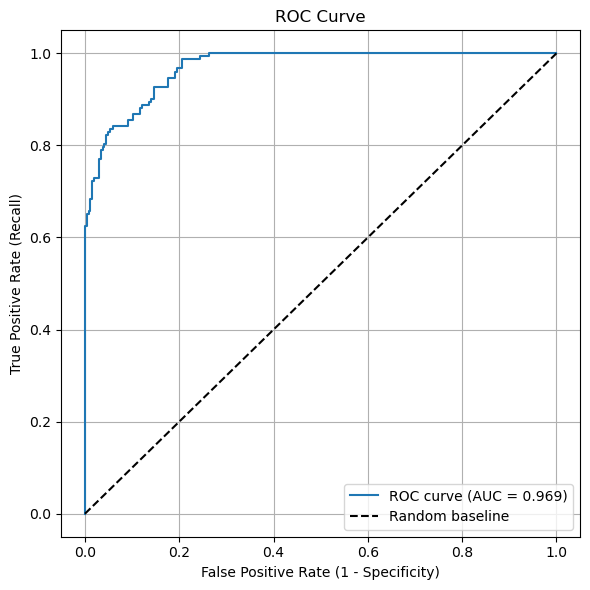

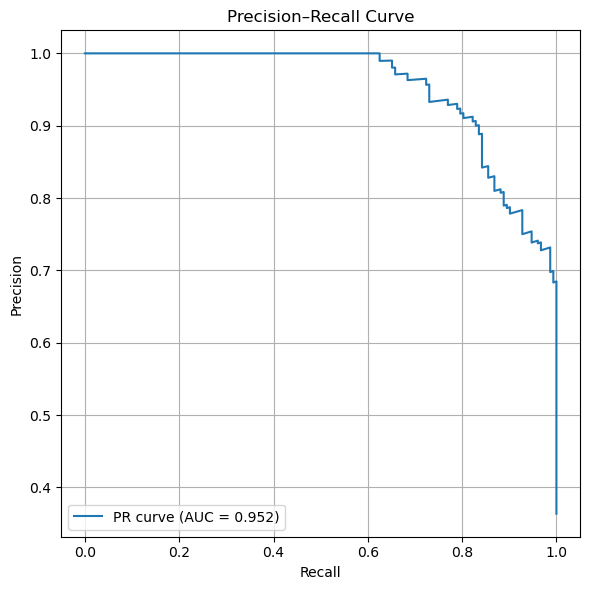

In [9]:
# --- Compute curves ---
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_true, y_proba)
pr_auc = auc(rec, prec)



f1_scores = 2 * prec * rec / (prec + rec)
best_idx = argmax(f1_scores)
best_thresh = _[best_idx]
print(f"Best threshold by F1-score: {best_thresh:.3f}")


# --- Plot ROC curve ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--", label="Random baseline")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Precision–Recall curve ---
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

## (Optional) Minimal drift glance vs. train summary (if summary was trained in 01)

In [10]:
# OPTIONAL: quick numeric mean delta vs stored training stats
# Example expects a JSON like {"columns": {"Age":"float64", ...}, "rows": 891,
#                              "numerics_mean": {"Age": 29.7, ...}, "numerics_std": {...}}
schema_path = "../outputs/schema.json"
if os.path.exists(schema_path):
    with open(schema_path, "r", encoding="utf-8") as f:
        schema = json.load(f)
    num_cols = [c for c,t in schema.get("columns", {}).items() if "float" in t or "int" in t]
    num_cols = [c for c in num_cols if c in df_raw.columns]
    if num_cols:
        print("\nNumeric mean deltas (|Δ| / (std_train + std_new)):")
        for c in num_cols:
            m_tr = schema.get("numerics_mean", {}).get(c)
            s_tr = schema.get("numerics_std", {}).get(c, 0)
            m_new = pd.to_numeric(df_raw[c], errors="coerce").mean()
            s_new = pd.to_numeric(df_raw[c], errors="coerce").std(ddof=0)
            denom = (s_tr or 0) + (s_new or 0)
            delta = abs(m_tr - m_new) / denom if (m_tr is not None and denom>0) else np.nan
            print(f"{c:12s}  {delta:.3f}")

## (Optional) Single-record scoring helper

In [11]:
def score_one(payload: dict) -> dict:
    """Score a single passenger dict (raw fields). Returns prob & pred."""
    df1 = pd.DataFrame([payload])
    
    # Clean string columns
    for c in df1.select_dtypes(include=["object", "string"]).columns:
        df1[c] = df1[c].astype("string").str.strip()

    # Predict probability
    p = clf.predict_proba(df1)[:, 1].ravel()[0]  # ✅ extrai escalar de forma segura

    return {
        "survival_prob": float(p),
        "survived_pred": int(p >= THRESHOLD)
    }

# Example:
score_one({
    "PassengerId": 9999, "Pclass": 1, "Name": "Doe, Mr. John", "Sex": "male",
    "Age": 38, "SibSp": 0, "Parch": 0, "Ticket": "A/5 21171", "Fare": 71.2833,
    "Cabin": "C85", "Embarked": "C"
})

{'survival_prob': 0.4893930955453964, 'survived_pred': 0}